In [1]:
import sys

sys.path.append("..")

import tensorflow as tf

import tensorflow_probability as tfp

import numpy as np

import GPyOpt

import argparse

from utils import tf_config, preprocess_data, search_algorithms, train, bnn_utils, outlier_utils, eeg_utils

import matplotlib.pyplot as plt

import gc

import os

from sklearn.model_selection import train_test_split, KFold

import time

dataset="01"
memory_limit=4000
n_individuals=8
interval_eeg=6

tf_config.set_seed(seed=42)
tf_config.setup_tensorflow(device="CPU", memory_limit=memory_limit)

with tf.device('/CPU:0'):
    train_data, val_data = preprocess_data.dataset(dataset, n_individuals=n_individuals, 
                                            interval_eeg=interval_eeg, 
                                            ind_volume_fit=False,
                                            standardize_fmri=True,
                                            iqr=False,
                                            verbose=True)
    eeg_train, fmri_train=train_data
    
    eeg_train = eeg_train.astype('float32')
    fmri_train = fmri_train.astype('float32')

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy
I: Starting to Load Data
I: Finished Loading Data
I: Pairs Created


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [3]:
eeg_train.shape

(1776, 64, 134, 6, 1)

In [4]:
fmri_train.shape

(1776, 64, 64, 30, 1)

In [225]:
channel_names = eeg_utils.get_eeg_instance_01(0).ch_names

channel_names = eeg_utils.get_eeg_instance_02([0]).ch_names

TypeError: list indices must be integers or slices, not list

In [173]:

from scipy.signal import correlate
import time


i=0
start_time = time.time()


for individual in range(eeg_train.shape[0]):
    
    freqs_x_channels = None
    freqs_y_channels = None
    freqs_z_channels = None
    
    for channel in range(eeg_train.shape[1]):
        
        freqs_x = None
        freqs_y = None
        freqs_z = None
        
        for frequency in range(eeg_train.shape[2]):
            
            
            corr_x = correlate(eeg_train[individual, channel, frequency,:]/np.linalg.norm(eeg_train[individual, channel, frequency,:]), 
                               fmri_train[individual,:,30,15]/np.linalg.norm(fmri_train[individual,:,30,15]))
            corr_y = correlate(eeg_train[individual, channel, frequency,:]/np.linalg.norm(eeg_train[individual, channel, frequency,:]), 
                               fmri_train[individual,30,:,15]/np.linalg.norm(fmri_train[individual,30,:,15]))
            corr_z = correlate(eeg_train[individual, channel, frequency,:]/np.linalg.norm(eeg_train[individual, channel, frequency,:]), 
                               fmri_train[individual,30,30,:]/np.linalg.norm(fmri_train[individual,30,30,:]))
            
            if(freqs_x is None):
                freqs_x, freqs_y, freqs_z = np.empty(shape=(eeg_train.shape[2],corr_x.shape[0])), np.empty(shape=(eeg_train.shape[2],corr_y.shape[0])), np.empty(shape=(eeg_train.shape[2],corr_z.shape[0]))
            
            
            freqs_x[frequency,:] = corr_x[:,0]
            freqs_y[frequency,:] = corr_y[:,0]
            freqs_z[frequency,:] = corr_z[:,0]
        
        
        
        freqs_x = np.nan_to_num(freqs_x)
        freqs_y = np.nan_to_num(freqs_y)
        freqs_z = np.nan_to_num(freqs_z)
        
        if(type(freqs_x_channels) == type(None)):
            freqs_x_channels, freqs_y_channels, freqs_z_channels = np.zeros((eeg_train.shape[1], eeg_train.shape[2], freqs_x.shape[1])), np.zeros((eeg_train.shape[1], eeg_train.shape[2], freqs_y.shape[1])), np.zeros((eeg_train.shape[1], eeg_train.shape[2], freqs_z.shape[1]))
            freqs_x_channels_ttest, freqs_y_channels_ttest, freqs_z_channels_ttest = np.empty(shape=(eeg_train.shape[1], eeg_train.shape[0]*eeg_train.shape[2]*freqs_x.shape[1])), np.empty(shape=(eeg_train.shape[1], eeg_train.shape[0]*eeg_train.shape[2]*freqs_y.shape[1])), np.empty(shape=(eeg_train.shape[1], eeg_train.shape[0]*eeg_train.shape[2]*freqs_z.shape[1]))
        
        freqs_x_channels[channel,:,:] += freqs_x
        freqs_y_channels[channel,:,:] += freqs_y
        freqs_z_channels[channel,:,:] += freqs_z
        
        freqs_x_channels_ttest[channel,i*freqs_x.shape[1]*eeg_train.shape[2]:(i+1)*freqs_x.shape[1]*eeg_train.shape[2]] += freqs_x.flatten()
        freqs_y_channels_ttest[channel,i*freqs_y.shape[1]*eeg_train.shape[2]:(i+1)*freqs_y.shape[1]*eeg_train.shape[2]] += freqs_y.flatten()
        freqs_z_channels_ttest[channel,i*freqs_z.shape[1]*eeg_train.shape[2]:(i+1)*freqs_z.shape[1]*eeg_train.shape[2]] += freqs_z.flatten()
        
    #channel increment after
    i+=1
        
    #if(individual % 50 == 0):
    print("Finished: ", individual+1, end="\r")
    
print("Took ", time.time()-start_time, "seconds")

freqs_x_channels[channel,:,:] /= eeg_train.shape[0]
freqs_y_channels[channel,:,:] /= eeg_train.shape[0]
freqs_z_channels[channel,:,:] /= eeg_train.shape[0]

Took  2571.8779389858246 seconds


In [174]:
freqs_x_mean = np.amax(freqs_x_channels, axis=2)

freqs_y_mean = np.amax(freqs_y_channels, axis=2)

freqs_z_mean = np.amax(freqs_z_channels, axis=2)

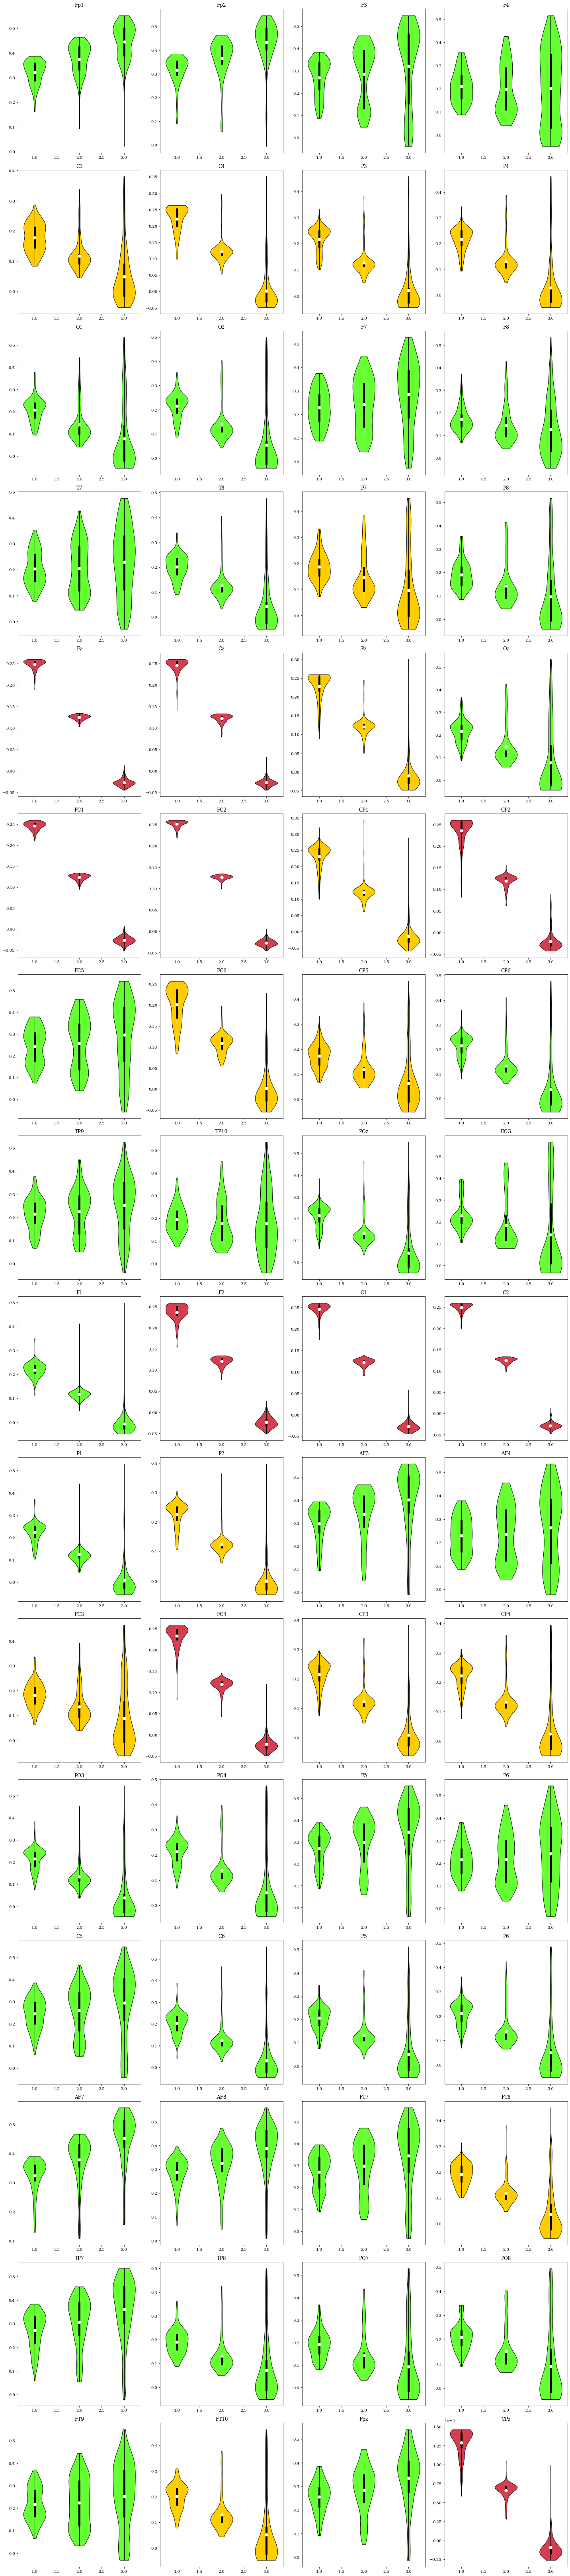

In [221]:
fig, axes = plt.subplots(eeg_train.shape[1]//4,4, figsize=(20,90))

i = 0
j = 0
for channel in range(eeg_train.shape[1]):
    
    if(j ==4):
        i+=1
        j=0
    parts = axes[i][j].violinplot([freqs_x_mean[channel,:], freqs_y_mean[channel,:], freqs_z_mean[channel,:]],
                           showmeans=False, showmedians=False,
            showextrema=False)
    
    
    if(np.mean(np.amax([freqs_x_mean[channel,:], freqs_y_mean[channel,:], freqs_z_mean[channel,:]], axis=1)) < 0.2):
        facecolor='#D43F50'
    elif(np.mean(np.amax([freqs_x_mean[channel,:], freqs_y_mean[channel,:], freqs_z_mean[channel,:]], axis=1)) < 0.4):
        facecolor='#ffcc00'
    else:
        facecolor="#66ff33"
    for pc in parts['bodies']:
        pc.set_facecolor(facecolor)
        pc.set_edgecolor('black')
        pc.set_alpha(1)


    quartile1, medians, quartile3 = np.percentile([freqs_x_mean[channel,:], freqs_y_mean[channel,:], freqs_z_mean[channel,:]], [25, 50, 75], axis=1)

    names = [1.0,2.0,3.0]
    axes[i][j].set_title(channel_names[channel])
    axes[i][j].scatter(names, np.mean([freqs_x_mean[channel,:], freqs_y_mean[channel,:], freqs_z_mean[channel,:]], axis=1), marker='o', color='white', s=50, zorder=3)
    axes[i][j].vlines(names, quartile1, quartile3, color='k', linestyle='-', lw=5)
    axes[i][j].vlines(names, np.amin([freqs_x_mean[channel,:], freqs_y_mean[channel,:], freqs_z_mean[channel,:]], axis=1), np.amax([freqs_x_mean[channel,:], freqs_y_mean[channel,:], freqs_z_mean[channel,:]], axis=1),color='k', linestyle='-', lw=1)
    axes[i][j].ticklabel_format(style="sci", scilimits=(-2,2))
    #plt.xticks([1.0,2.0,3.0], ["x-axis", "y-axis", "z-axis"])
    
    j+=1

plt.rc('font', family='serif')
plt.tight_layout()

if(dataset = "01"):
    fig.savefig("violin_channels_ds0001.pdf", format="pdf")
elif(dataset = "02"):
    fig.savefig("violin_channels_ds0002.pdf", format="pdf")
else:
    fig.savefig("violin_channels_ds0002.pdf", format="pdf")

## Run t test

In [180]:

for channel in range(eeg_train.shape[1]):
    if(shapiro(freqs_x_channels_ttest[channel,:]).pvalue > 0.0):
        print("Normal distribution")

In [181]:
#test normality
from scipy.stats import shapiro


from scipy.stats import ttest_ind



pvalue_img = np.zeros((eeg_train.shape[1], eeg_train.shape[1]))



for channel1 in range(eeg_train.shape[1]):
    for channel2 in range(eeg_train.shape[1]):
        
        tvalue, pvalue = ttest_ind(freqs_x_channels_ttest[channel1,:], freqs_x_channels_ttest[channel2,:])
        
        pvalue_img[channel1, channel2] = pvalue

In [200]:
pvalue_img_pixels = (pvalue_img <= 0.05).astype("int32")
channel_names = eeg_utils.get_eeg_instance_01(0).ch_names
#pvalue_img_pixels = pvalue_img

<function matplotlib.pyplot.show(close=None, block=None)>

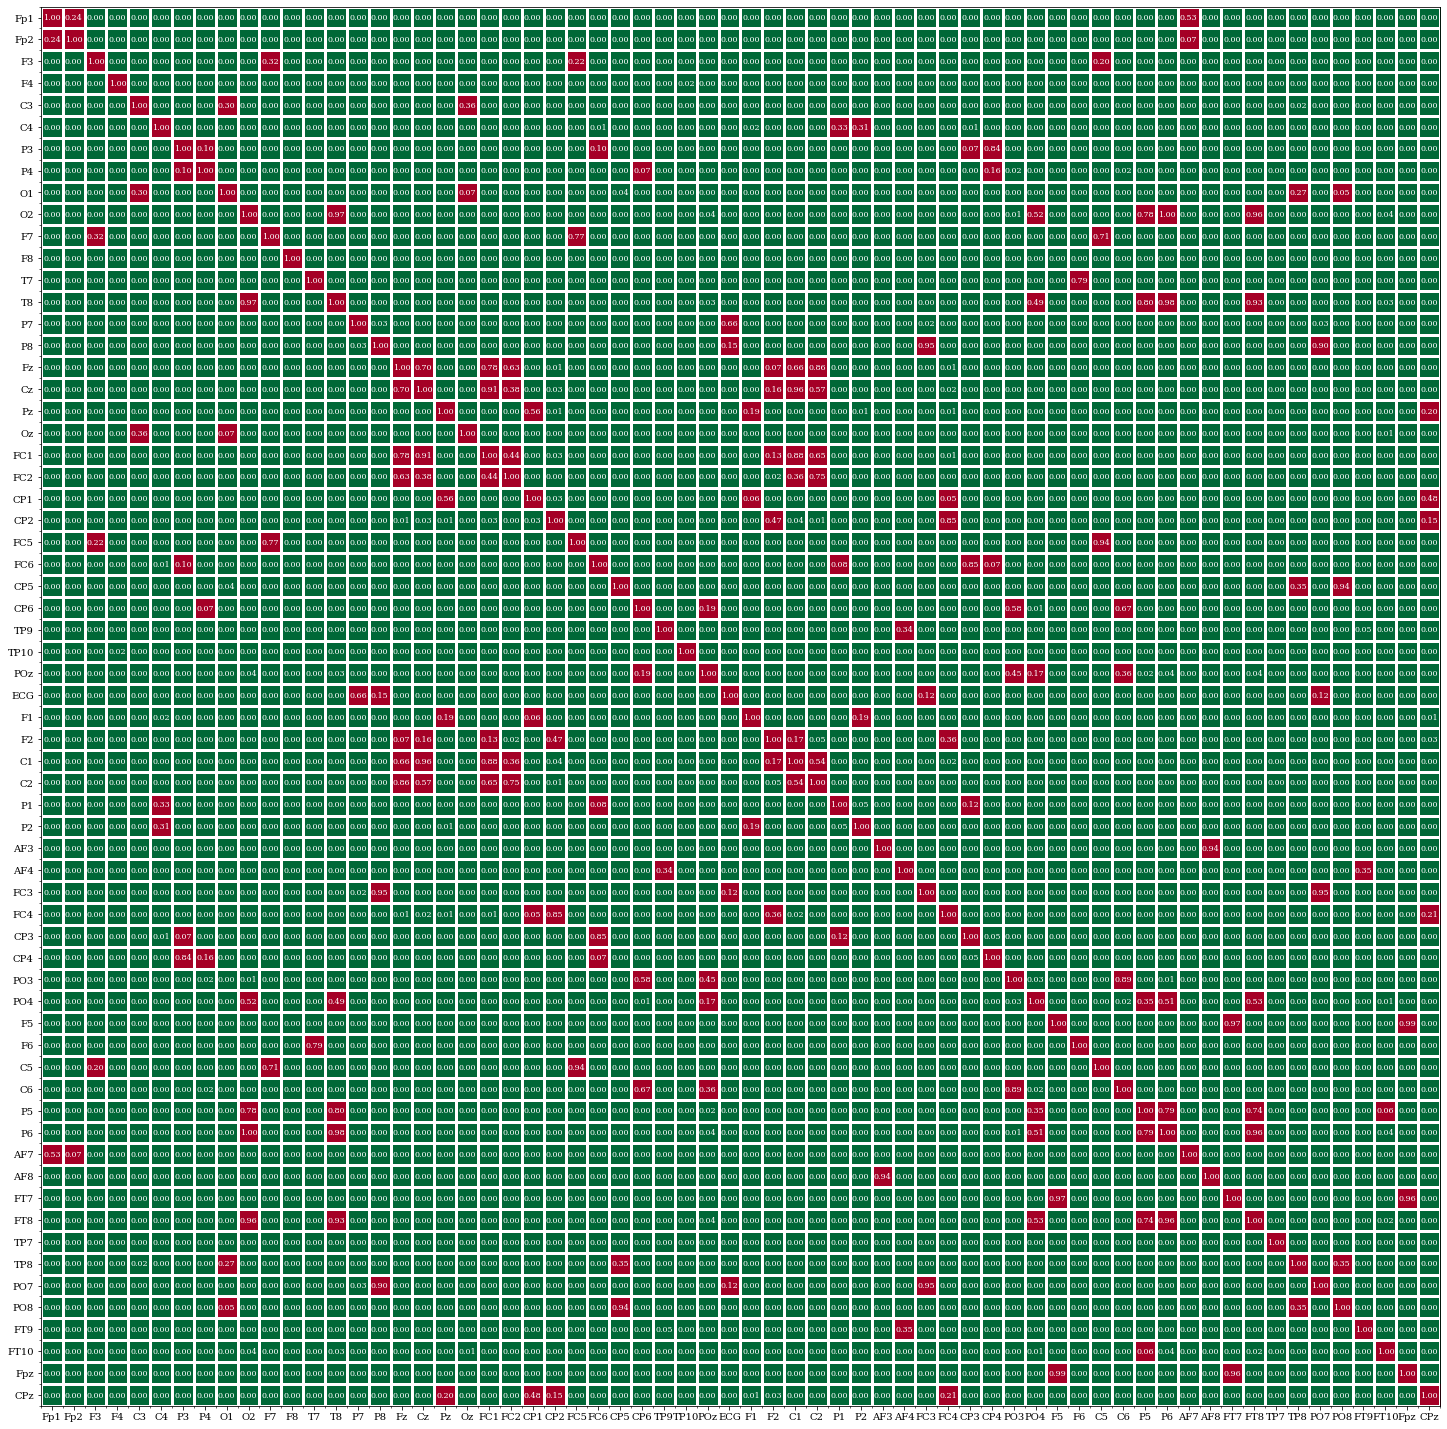

In [223]:
fg = plt.figure(figsize=(20,20))
ax = plt.gca()

img = ax.imshow(pvalue_img_pixels, cmap="RdYlGn")

plt.xticks(np.arange(0,len(channel_names)), channel_names)
plt.yticks(np.arange(0,len(channel_names)), channel_names)

ax.set_xticks(np.arange(len(channel_names)+1)-.5, minor=True)
ax.set_yticks(np.arange(len(channel_names)+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)

plt.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

for i in range(pvalue_img.shape[0]):
    for j in range(pvalue_img.shape[1]):
        img.axes.text(j-0.40, i+0.1, "{:.2f}".format(pvalue_img[i, j]), fontsize=8,
                      color="white")

plt.rc('font', family='serif')
plt.tight_layout()

if(dataset = "01"):
    fig.savefig("violin_channels_ds0001.pdf", format="pdf")
elif(dataset = "02"):
    fig.savefig("violin_channels_ds0002.pdf", format="pdf")
else:
    fig.savefig("violin_channels_ds0002.pdf", format="pdf")